## Taxi/Ride-share Demand Forecasting & Supply Optimization


### Business Problem

Ride-share and taxi services face significant operational challenges due to fluctuating customer demand throughout the day, week, and seasons.

Companies like Uber, Lyft, Ola, and local taxi firms must:

- Anticipate high-demand periods to allocate enough drivers and vehicles.

- Avoid oversupply during low-demand windows, which leads to wasted resources and higher costs.

- Respond to rapid changes due to weather, events, local disruptions, or holidays.

- Failure to predict demand accurately results in:

- Longer passenger wait times

- Driver dissatisfaction/loss of earnings

- Lower utilization rates

- Lost revenue due to missed trips or surge pricing backlash

- Customer churn in competitive markets

### Use Case
Predicting taxi and ride-share demand for specific locations and time periods using machine learning.
The model will empower operations teams to:

📍 Forecast the number of rides/hails at different times, locations, and conditions.

🚕 Optimize driver deployment, reducing idle time and maximizing coverage where needed most.

📈 Plan surge pricing and incentives for drivers in advance of peak demand.

🕰️ Improve customer experience by minimizing wait times and missed connections.

🗺️ Support strategic business decisions—expanding coverage areas, targeting marketing, and resource planning.

### Example Use Case Scenarios
- Morning/evening rush hour: Forecast increased demand near business districts and transit hubs.

- Event-driven surges: Anticipate spikes after concerts, sports games, or festivals.

- Weather-related impacts: Predict reduced or increased demand during rain, snow, or extreme temperatures.

- Holiday fluctuations: Plan for upswings or drops on holidays, weekends, or school breaks.

### Who Benefits
- Dispatch Managers: Allocate vehicles and drivers more productively.

- Drivers: Improve earning potential by working in high-demand areas/times.

- Operations Teams: Reduce overhead while improving service levels.

- Customers: Experience shorter waits and more reliable service.

### In summary:
The target is to deliver an accurate, actionable ride demand forecasting tool so that taxi/ride-share companies can optimize operations, boost revenue, and deliver exceptional customer experiences.


### 🎯 Project Objective
- Develop an automated, data-driven system to accurately forecast real-time ride demand across urban zones, optimize driver allocation, and minimize passenger wait times for a fictitious ride-share platform—OrionCab.

- This project leverages machine learning algorithms, time series analysis, and geospatial features to anticipate surge events, address supply-demand mismatches, and improve overall fleet efficiency.

### Key objectives:

- Predict hourly and zonal ride demand using historical trip, event, weather, and traffic data.

- Suggest optimal driver distribution strategies to maximize completed rides and revenue.

- Alert operations teams to impending demand surges or supply shortages.

- Provide actionable analytics dashboards for business teams to review forecasts, locations, and KPIs.

### ❓ Core Questions Addressed
- Where and when will ride demand surge in the next hour/day/week?

- How many drivers should be available in each hot zone to minimize wait times and maximize ride acceptance?

- What external factors (weather, events, holidays) most impact demand patterns?

- Can we proactively re-allocate or incentivize drivers to avoid supply shortages?

- How do changes in supply (e.g., number of drivers online) affect rider wait time and conversion rates?

- What are the trends in demand over time, and how can future supply policies be planned?



### Ingesting Weather Data

In [1]:
url = "https://archive-api.open-meteo.com/v1/archive?latitude=40.7128&longitude=-74.0060&start_date=2025-01-01&end_date=2025-03-31&hourly=temperature_2m,precipitation,weathercode&timezone=America/New_York"

In [2]:
import os
import requests
import json

os.makedirs('Data', exist_ok=True)

response = requests.get(url)
data = response.json()

# Save as JSON
with open('Data/nyc_weather_jan_mar_2025.json', 'w') as f:
    json.dump(data, f)

### Convert json to DataFrame (to merge with Taxi trip data)

In [2]:
import pandas as pd
import json

with open('Data/nyc_weather_jan_mar_2025.json', 'r') as f:
    weather = json.load(f)

df_weather = pd.DataFrame({
    'datetime': weather['hourly']['time'],
    'temperature_2m': weather['hourly']['temperature_2m'],
    'precipitation': weather['hourly']['precipitation'],
    'weathercode': weather['hourly']['weathercode']
})

df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
print(df_weather.head())

             datetime  temperature_2m  precipitation  weathercode
0 2025-01-01 00:00:00             7.9            3.4           63
1 2025-01-01 01:00:00             8.9            0.9           53
2 2025-01-01 02:00:00             8.5            0.0            3
3 2025-01-01 03:00:00             8.7            0.0            3
4 2025-01-01 04:00:00             8.6            0.0            3


In [4]:
df_weather.head()

,datetime,temperature_2m,precipitation,weathercode
0,2025-01-01 00:00:00,7.9,3.4,63
1,2025-01-01 01:00:00,8.9,0.9,53
2,2025-01-01 02:00:00,8.5,0.0,3
3,2025-01-01 03:00:00,8.7,0.0,3
4,2025-01-01 04:00:00,8.6,0.0,3


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        2160 non-null   datetime64[ns]
 1   temperature_2m  2160 non-null   float64       
 2   precipitation   2160 non-null   float64       
 3   weathercode     2160 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 67.6 KB


### Let's Concatenate the trip data

In [6]:
files = [
    'Data/yellow_tripdata_2025-01.parquet',
    'Data/yellow_tripdata_2025-02.parquet',
    'Data/yellow_tripdata_2025-03.parquet',
]


# Read each parquet file into a DataFrame and concatente all 3
df_taxi = pd.concat((pd.read_parquet(f, engine='fastparquet') for f in files), ignore_index=True)
print(f'Taxi data shape: {df_taxi.shape}')

Taxi data shape: (11198026, 20)


### Prepare Pickup Hour for Merging

In [7]:
df_taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')

In [8]:
import pandas as pd

# Convert pick-up datetime column to pandas datetime type
df_taxi['tpep_pickup_datetime'] = pd.to_datetime(df_taxi['tpep_pickup_datetime'])

# Create 'pickup_hour' by flooring to the nearest hour (for merging with hourly weather)
df_taxi['pickup_hour'] = df_taxi['tpep_pickup_datetime'].dt.floor('h')

# Localize to New York timezone
df_taxi['pickup_hour'] = df_taxi['pickup_hour'].dt.tz_localize('America/New_York')

# Check sample
print(df_taxi[['tpep_pickup_datetime', 'pickup_hour']].head())

  tpep_pickup_datetime               pickup_hour
0  2025-01-01 00:18:38 2025-01-01 00:00:00-05:00
1  2025-01-01 00:32:40 2025-01-01 00:00:00-05:00
2  2025-01-01 00:44:04 2025-01-01 00:00:00-05:00
3  2025-01-01 00:14:27 2025-01-01 00:00:00-05:00
4  2025-01-01 00:21:34 2025-01-01 00:00:00-05:00


### Aggregate Taxi Data by Hour and Zone

In [9]:
# Aggregate ride counts by pickup_hour and PULocationID (pickup zone)
agg_taxi = df_taxi.groupby(['pickup_hour', 'PULocationID']).size().reset_index(name='ride_count')

print(f'Aggregated taxi data shape: {agg_taxi.shape}')
print(agg_taxi.head())

Aggregated taxi data shape: (321955, 3)
                pickup_hour  PULocationID  ride_count
0 2007-12-05 18:00:00-05:00           142           1
1 2009-01-01 00:00:00-05:00           138           1
2 2024-12-31 20:00:00-05:00            48           1
3 2024-12-31 20:00:00-05:00           246           1
4 2024-12-31 20:00:00-05:00           249           1


In [10]:
# Define date range covering your weather data period
start_date = pd.Timestamp('2025-01-01').tz_localize('America/New_York')
end_date = pd.Timestamp('2025-03-31 23:59:59').tz_localize('America/New_York')

# Filter taxi data to this date range on pickup_hour
agg_taxi_filtered = agg_taxi[
    (agg_taxi['pickup_hour'] >= start_date) &
    (agg_taxi['pickup_hour'] <= end_date)
].copy()

print(f'Filtered taxi aggregate shape: {agg_taxi_filtered.shape}')

Filtered taxi aggregate shape: (321933, 3)


### Localize df_weather['datetime'] to America/New_York timezone

In [11]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['datetime'] = df_weather['datetime'].dt.tz_localize('America/New_York', nonexistent='shift_forward')

### Merge Aggregated Taxi Data with Weather Data

In [13]:
merged_agg = pd.merge(
    agg_taxi_filtered,
    df_weather,
    left_on='pickup_hour',
    right_on='datetime',
    how='left'
)

# Optionally drop redundant 'datetime' column
merged_agg.drop(columns=['datetime'], inplace=True)

print(f'Merged aggregated data shape: {merged_agg.shape}')
print(merged_agg.head())

Merged aggregated data shape: (322091, 6)
                pickup_hour  PULocationID  ride_count  temperature_2m  \
0 2025-01-01 00:00:00-05:00             4          28             7.9   
1 2025-01-01 00:00:00-05:00             7          12             7.9   
2 2025-01-01 00:00:00-05:00             9           1             7.9   
3 2025-01-01 00:00:00-05:00            10           1             7.9   
4 2025-01-01 00:00:00-05:00            12           1             7.9   

   precipitation  weathercode  
0            3.4           63  
1            3.4           63  
2            3.4           63  
3            3.4           63  
4            3.4           63  


In [14]:
merged_agg.shape

(322091, 6)

In [15]:
merged_agg.to_csv('Data/nyc_taxi_weather_agg_jan_mar_2025.csv', index=False)

## Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('Data/nyc_taxi_weather_agg_jan_mar_2025.csv')

# Convert pickup_hour column to datetime with UTC parsing
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)

# Convert from UTC to America/New_York timezone
df['pickup_hour'] = df['pickup_hour'].dt.tz_convert('America/New_York')

# Now you can safely extract time features
df['hour'] = df['pickup_hour'].dt.hour
df['day_of_week'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month

df.head()

,pickup_hour,PULocationID,ride_count,temperature_2m,precipitation,weathercode,hour,day_of_week,month
0,2025-01-01 00:00:00-05:00,4,28,7.9,3.4,63,0,2,1
1,2025-01-01 00:00:00-05:00,7,12,7.9,3.4,63,0,2,1
2,2025-01-01 00:00:00-05:00,9,1,7.9,3.4,63,0,2,1
3,2025-01-01 00:00:00-05:00,10,1,7.9,3.4,63,0,2,1
4,2025-01-01 00:00:00-05:00,12,1,7.9,3.4,63,0,2,1


#### Let us gather information about our data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322091 entries, 0 to 322090
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype                           
---  ------          --------------   -----                           
 0   pickup_hour     322091 non-null  datetime64[ns, America/New_York]
 1   PULocationID    322091 non-null  int64                           
 2   ride_count      322091 non-null  int64                           
 3   temperature_2m  322091 non-null  float64                         
 4   precipitation   322091 non-null  float64                         
 5   weathercode     322091 non-null  int64                           
 6   hour            322091 non-null  int32                           
 7   day_of_week     322091 non-null  int32                           
 8   month           322091 non-null  int32                           
dtypes: datetime64[ns, America/New_York](1), float64(2), int32(3), int64(3)
memory usage: 18.4 MB


There are about 7 independent features and 1 independent (ride_count) variables with 3,22,091 observations.

#### Decription of numeric features

In [5]:
df.describe()

,PULocationID,ride_count,temperature_2m,precipitation,weathercode,hour,day_of_week,month
count,322091.000000,322091.000000,322091.000000,322091.000000,322091.000000,322091.000000,322091.000000,322091.000000
mean,138.615630,34.785812,2.273975,0.141330,8.871986,11.996175,3.083048,2.079794
std,76.198847,74.865167,6.503614,0.732707,19.609496,6.619873,2.017311,0.822089
min,1.000000,1.000000,-16.800000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,73.000000,1.000000,-2.100000,0.000000,0.000000,7.000000,1.000000,1.000000
50%,141.000000,4.000000,1.700000,0.000000,2.000000,12.000000,3.000000,2.000000
75%,210.000000,23.000000,6.600000,0.000000,3.000000,18.000000,5.000000,3.000000
max,265.000000,1064.000000,26.200000,13.100000,75.000000,23.000000,6.000000,3.000000


#### Checking for Missing Values

In [6]:
print(df.isnull().sum())

pickup_hour       0
PULocationID      0
ride_count        0
temperature_2m    0
precipitation     0
weathercode       0
hour              0
day_of_week       0
month             0
dtype: int64


As we can see, there are no missing values in our dataset.

### Let us visualize our data

#### Distribution of Target Variable (ride_count)

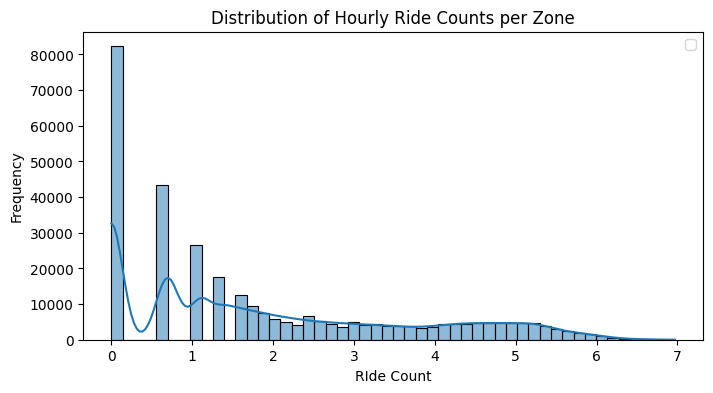

In [ ]:
plt.figure(figsize= (8, 4))
sns.histplot(np.log(df['ride_count']), bins = 50, kde = True)
plt.title("Distribution of Hourly Ride Counts per Zone")
plt.xlabel("RIde Count")
plt.ylabel("Frequency")
plt.show()

- The hourly ride counts per zone are highly skewed, with most (hour, zone) pairs having low demand and a small number of instances with very high demand.

- This indicates that taxi demand is sparse across many zones and hours, with occasional spikes in usage.

- Modeling should account for this imbalance and potential outliers.

#### Rides Over Time: Macro Trends

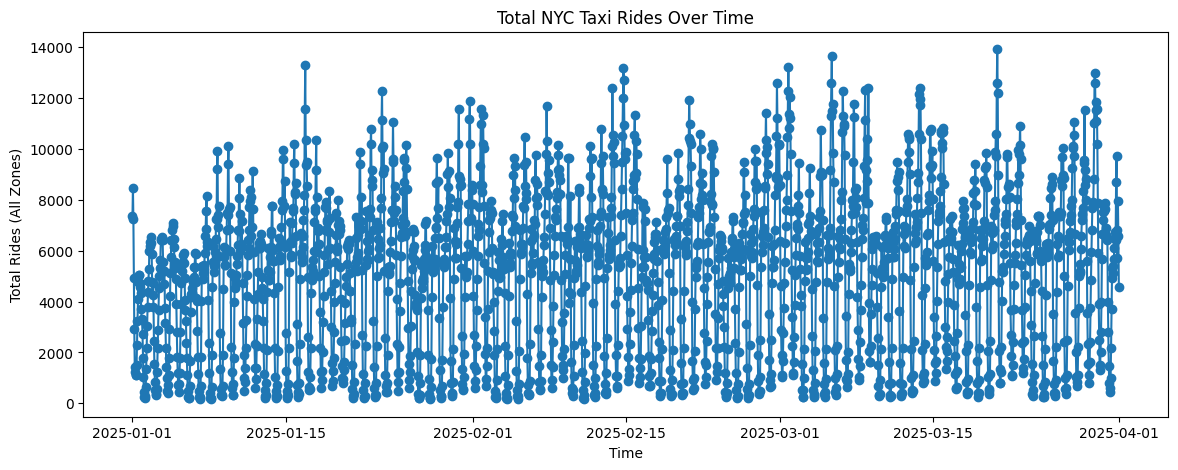

In [11]:
dt_time = df.groupby('pickup_hour')['ride_count'].sum().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(dt_time['pickup_hour'], dt_time['ride_count'], marker='o')
plt.title('Total NYC Taxi Rides Over Time')
plt.xlabel('Time')
plt.ylabel('Total Rides (All Zones)')
plt.show()

- Total taxi rides across NYC exhibit strong daily and weekly seasonality patterns.

- There are regular peaks during specific hours aligning with typical commuting times and weekends showing differing demand.

- Presence of spikes and dips suggests the effect of events, holidays, or weather-related changes in supply and demand.

#### Demand Patterns by Time and Day of Week

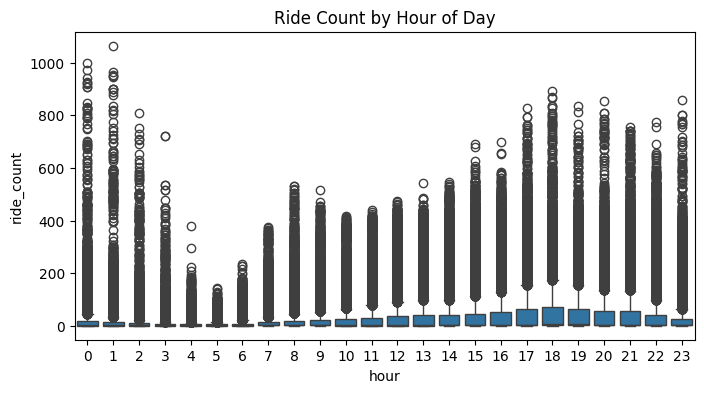

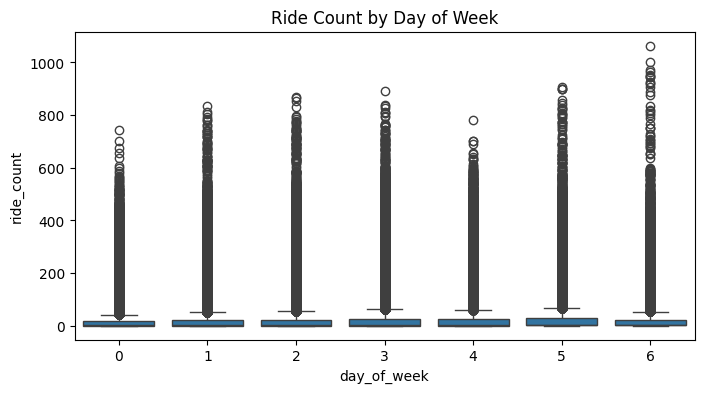

In [13]:
# Demand Patterns by Hour of Day
plt.figure(figsize=(8, 4))
sns.boxplot(x = 'hour', y = 'ride_count', data = df)
plt.title('Ride Count by Hour of Day')
plt.show()

# Demand Patterns by Day of Week
plt.figure(figsize=(8, 4))
sns.boxplot(x = 'day_of_week', y = 'ride_count', data = df)
plt.title('Ride Count by Day of Week')
plt.show()

For Ride Count by Hour of Day,

- Demand varies significantly by hour of the day with lowest rides in early morning (around 3-5 AM) and peak demand in the evening hours (around 5-8 PM).

- There is a clear daily cycle with morning and evening rush hours visible.

- Time-of-day is a critical feature for forecasting.

### Ride Count by Day of Week
- Ride counts are relatively stable across the weekdays but show slightly higher variability and peaks on weekends (especially Friday and Saturday).

- This indicates weekly seasonality with moderate weekend demand surges.

- Day of week is an important categorical feature for the model.

#### Spatial Demand: Top Pickup Zones

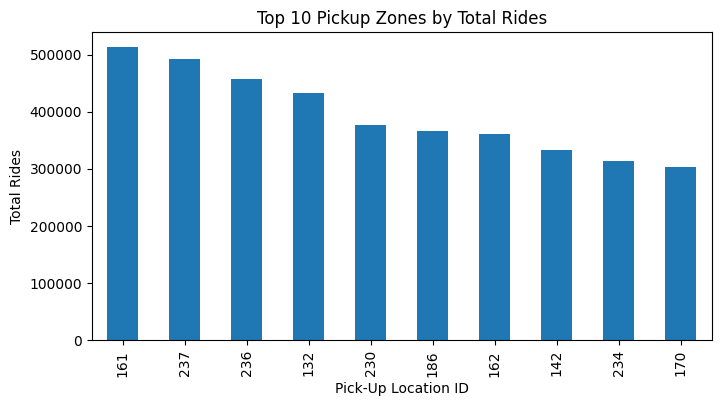

In [14]:
zone_counts = df.groupby('PULocationID')['ride_count'].sum().sort_values(ascending= False).head(10)
zone_counts.plot(kind = 'bar', figsize = (8, 4))
plt.title('Top 10 Pickup Zones by Total Rides')
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Total Rides')
plt.show()

- A few zones contribute disproportionately to the overall taxi demand, with the top zone exceeding 500,000 rides in the period.

- These high-demand zones are likely key transport hubs or commercial centers.

- Location encoding and possibly separate modeling for high-demand zones may improve forecasting accuracy.

#### Weather Impacct: Demand vs Weather

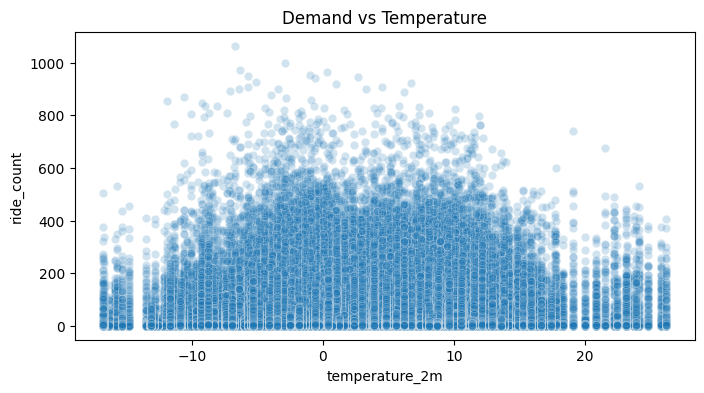

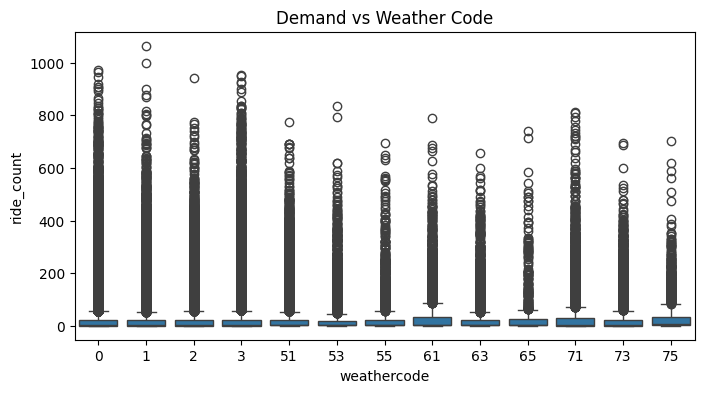

In [15]:
# Demand vs Temperature
plt.figure(figsize=(8, 4))
sns.scatterplot(x = 'temperature_2m', y = 'ride_count', data = df, alpha = 0.2)
plt.title('Demand vs Temperature')
plt.show()

# Demand vs Weathre Code
plt.figure(figsize=(8, 4))
sns.boxplot(x = 'weathercode', y = 'ride_count', data = df)
plt.title('Demand vs Weather Code')
plt.show()

For Demand vs Temperature, 
- Demand is spread across all temperatures observed, peaking modestly in moderate temperature ranges.

- No strong linear relationship exists between temperature and ride demand, pointing to potential non-linear effects.

- Temperature remains a relevant weather variable to include in modeling.

For Demand vs Weather Code, 
- Ride demand distributions are fairly consistent across different weather codes though some weather conditions are associated with more variability and higher demand outliers.

- Weather moderately influences ride counts; therefore, weather code should be included as a categorical feature.

### Correlation Heatmap

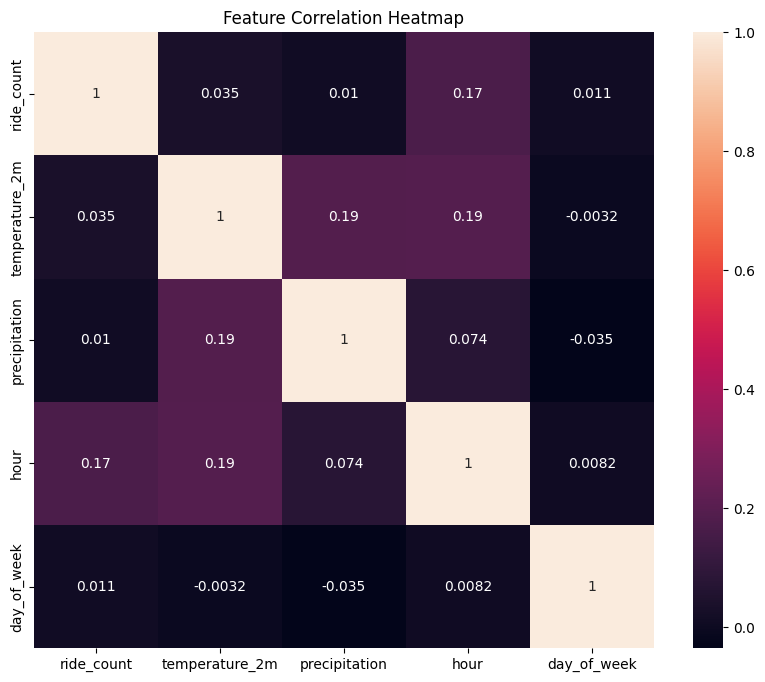

In [18]:
plt.figure(figsize= (10, 8))
sns.heatmap(df[['ride_count', 'temperature_2m', 'precipitation', 'hour', 'day_of_week']].corr(), annot = True)
plt.title('Feature Correlation Heatmap')
plt.show()

The highest positive correlation with ride count is the hour of day (~0.17), reinforcing the strong daily cyclic pattern.

Weather features and day of week show very weak linear correlations with demand.

The weak linear relationships indicate underlying complex interactions best modeled with advanced methods such as deep learning.

### Check for Outliers or Anomalies

In [19]:
print(df[df['ride_count'] > df['ride_count'].quantile(0.99)] )

                     pickup_hour  PULocationID  ride_count  temperature_2m  \
229    2025-01-01 01:00:00-05:00            79         474             8.9   
434    2025-01-01 02:00:00-05:00            79         492             8.5   
631    2025-01-01 03:00:00-05:00            79         447             8.7   
2541   2025-01-01 16:00:00-05:00           132         374             6.7   
2662   2025-01-01 17:00:00-05:00           132         396             5.8   
...                          ...           ...         ...             ...   
321441 2025-03-31 20:00:00-04:00           161         458            17.4   
321621 2025-03-31 21:00:00-04:00           161         513            16.6   
321668 2025-03-31 21:00:00-04:00           230         396            16.6   
321865 2025-03-31 22:00:00-04:00           230         414            15.8   
321985 2025-03-31 23:00:00-04:00           132         409            15.9   

        precipitation  weathercode  hour  day_of_week  month  


Data contains valid high-demand outliers mostly from specific zones and time periods.

These spikes often occur in major pickup zones and during late evenings or in adverse weather conditions.

The model should be robust to such outliers when forecasting taxi demand.

### General Summary of EDA and Correlation Analysis
The EDA on NYC taxi demand aggregated by hour and pickup zone reveals clear and expected temporal, spatial, and weather-related patterns:

- <b>Temporal Patterns</b>: Taxi demand exhibits strong daily and weekly seasonality, with peaks during typical commuting hours and higher demand on weekends. The hour of the day shows the strongest correlation with demand, emphasizing its importance as a predictive feature.

- <b>Spatial Concentration</b>: A small number of pickup zones dominate the demand, with the top zones serving as major activity centers and transportation hubs. This spatial skewness suggests location embeddings or tailored zone-level modeling could improve demand forecasts.

- <b>Demand Distribution</b>: The hourly ride counts per zone have a highly right-skewed distribution. While most hour-zone pairs experience low to moderate demand, notable outliers represent significant demand surges, often coinciding with specific zones, times, and weather conditions.

- <b>Weather Influence</b>: Weather variables such as temperature, precipitation, and discrete weather codes have relatively weak linear correlations with demand but show patterns consistent with intuition—adverse or extreme weather can influence ride frequency. The subtle and potentially non-linear impact of weather favors inclusion of these features in deep learning models that can capture complex relationships.

- <b>Correlation Insights</b>: Low linear correlations between ride_count and continuous features indicate that demand is driven by complex interactions rather than single predictors. The hour feature’s moderate correlation aligns with temporal cyclicality observed in the data.

- <b>Outliers and Spikes</b>: High ride count outliers are generally valid and concentrated in major zones and peak hours or under particular weather conditions. Models should incorporate robust techniques to handle these spikes for accurate prediction.

These findings establish a strong foundation for feature engineering and advanced modeling. They highlight the critical role of time, location, and weather in shaping taxi demand, while reinforcing the need for flexible models like deep learning to capture intricate patterns beyond simple linear effects.

### Let us add a is_weekend feature to our dataframe

In [27]:
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

### Let us save the dataframe as a csv file and move to Feature Engineering and Modeling Building

In [28]:
df.to_csv('Data/nyc_taxi_weather_agg_jan_mar_2025_cleaned.csv', index=False)